<a href="https://colab.research.google.com/github/yepe4401/BBC-News-Clasification/blob/main/bbc_news_classification_using_nmf_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/learn-ai-bbc/

/content/drive/My Drive/learn-ai-bbc


In [4]:
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')

In [5]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


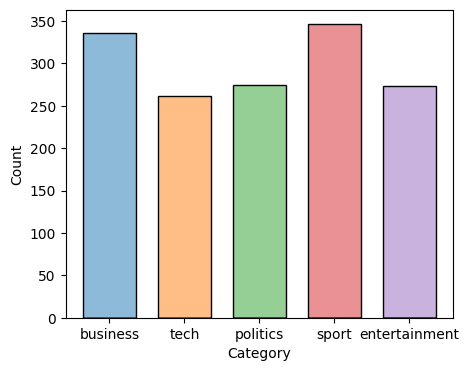

In [7]:
plt.figure(figsize=(5, 4))
sns.histplot(train, x='Category', hue='Category', shrink=0.7, legend=False);

In [8]:
class_counts = train.Category.value_counts()
class_counts

,count
Category,
sport,346
business,336
politics,274
entertainment,273
tech,261


In [ ]:
n_majority_class = class_counts.loc['sport']
n_minority_class = class_counts.loc['tech']
imbalanced_ratio = n_majority_class / n_minority_class
imbalanced_ratio

1.3256704980842913

In [9]:
train_stats = train[['Text', 'Category']]
train_stats['word_count'] = train_stats.Text.apply(lambda x: len(x.split()))
train_stats[['Category', 'word_count']].groupby('Category').describe()


word_count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           336.0  334.169643  133.527272  145.0  253.00  304.0   
entertainment      273.0  333.912088  203.887349  144.0  229.00  272.0   
politics           274.0  449.689781  258.836242   90.0  319.25  441.5   
sport              346.0  335.346821  185.443084  116.0  210.25  294.5   
tech               261.0  501.858238  211.672986  188.0  340.00  457.0   

                               
                  75%     max  
Category                       
business       391.25   902.0  
entertainment  380.00  2448.0  
politics       527.00  3345.0  
sport          412.75  1671.0  
tech           633.00  1549.0

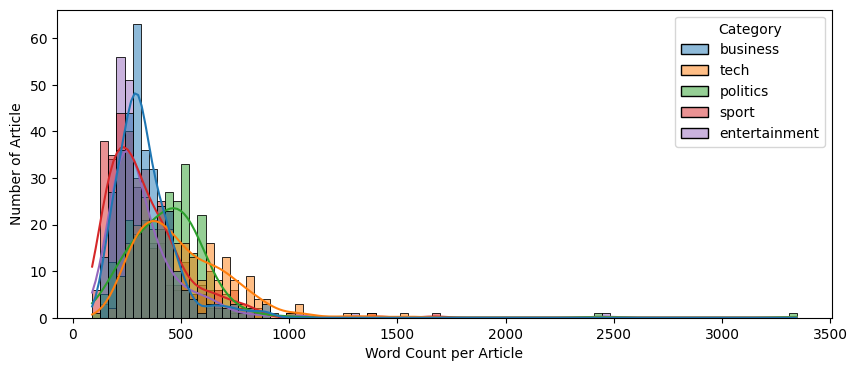

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(train_stats, x='word_count', hue='Category', kde=True)
plt.xlabel('Word Count per Article')
plt.ylabel('Number of Article');

In [11]:
label_names = train.Category.unique().tolist()
label_names

['business', 'tech', 'politics', 'sport', 'entertainment']

In [13]:
mapping = dict(zip(label_names, list(range(5))))
mapping

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [14]:
train['labels'] = [mapping[c] for c in train.Category]
train.tail()

,ArticleId,Text,Category,labels
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,1
1489,538,santy worm makes unwelcome visit thousands of ...,tech,1


In [15]:
y = train.labels.tolist()

In [17]:

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# DTM: Document Term Matrix
DTM = tfidf_vectorizer.fit_transform(train.Text)

feature_names = tfidf_vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(DTM.toarray(), columns=feature_names)
print('Document Term Matrix size:', DTM_df.shape)
DTM_df.head()

Document Term Matrix size: (1490, 14066)


,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
model_nmf = NMF(n_components=5, init='nndsvd', beta_loss='frobenius', solver='cd', max_iter=200).fit(DTM)
W = model_nmf.transform(DTM)
H = model_nmf.components_

In [19]:
def plot_top_features(H, feature_names):
    plt.figure(figsize=(24, 16))
    for i, topic in enumerate(H):
        plt.subplot(231+i)
        top_features_ind = topic.argsort()[-20:]
        top_features_names = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        plt.barh(top_features_names, weights, height=0.7)
        plt.yticks(fontsize=16)
        plt.title(f'Topic {i+1}', fontsize=24)
    plt.tight_layout()

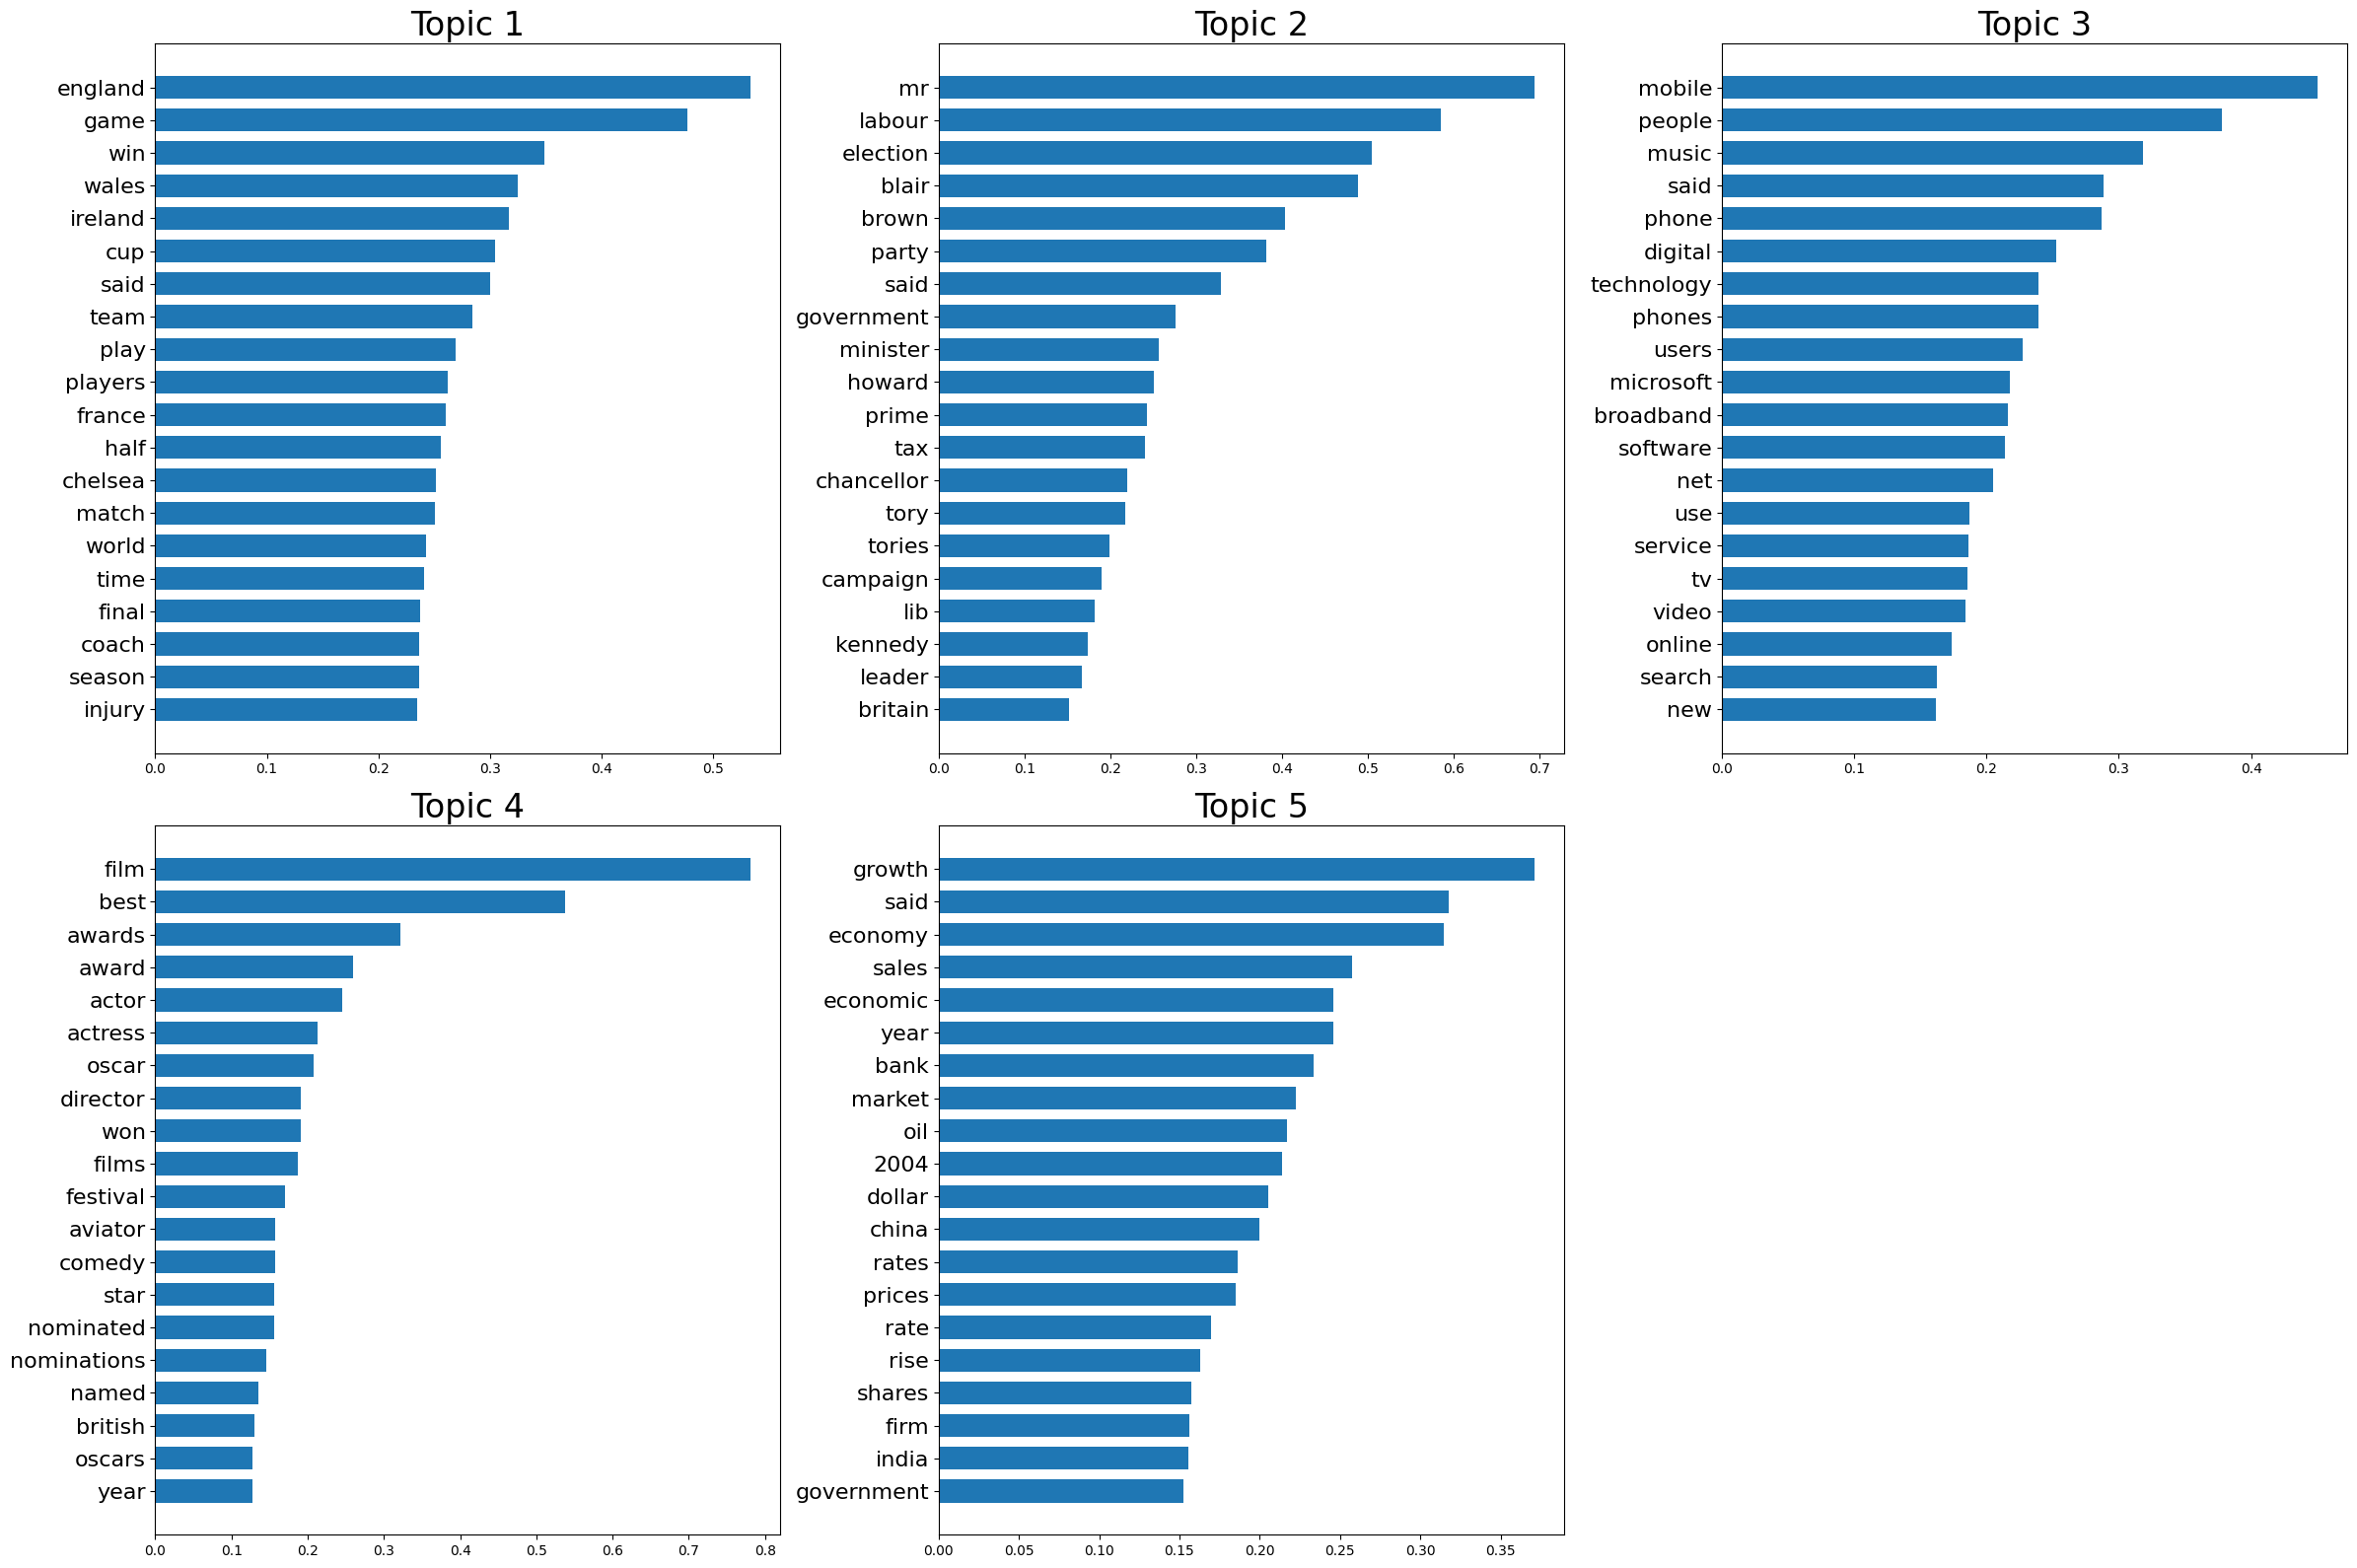

In [20]:
plot_top_features(H, feature_names)


In [21]:
pd.DataFrame(W).head()

,0,1,2,3,4
0,0.000714,0.039402,0.008729,0.003573,0.049935
1,0.000000,0.000000,0.000000,0.000000,0.216448
2,0.014828,0.022710,0.025921,0.000517,0.121552
3,0.000000,0.000000,0.225295,0.000000,0.000000
4,0.006076,0.005453,0.010081,0.008343,0.073212


In [25]:
predictions = np.argmax(W, axis=1)

In [23]:
BEST_ORDERING = None

def label_permute_compare(y, yp):
    unique_labels = np.unique(yp)
    ordering = permutations(unique_labels)
    best_accuracy = 0.0
    global BEST_ORDERING

    for order in ordering:
        # Create a mapping of yp according to order
        label_mapping = dict(zip(unique_labels, order))
        reordered_yp = np.array([label_mapping[lbl] for lbl in yp])

        curr_score = accuracy_score(y, reordered_yp)
        if curr_score > best_accuracy:
            best_accuracy = curr_score
            BEST_ORDERING = order

    return best_accuracy

In [24]:
print('Accuracy score for NMF model with beta_loss="frobenius":')
label_permute_compare(y, predictions)

Accuracy score for NMF model with beta_loss="frobenius":


0.9194630872483222

In [26]:
# use BEST_ORDERING that was assigned the best labelorder in label_permute_compare(), to map predictions
unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, BEST_ORDERING))
reordered_yp = np.array([label_mapping[lbl] for lbl in predictions])

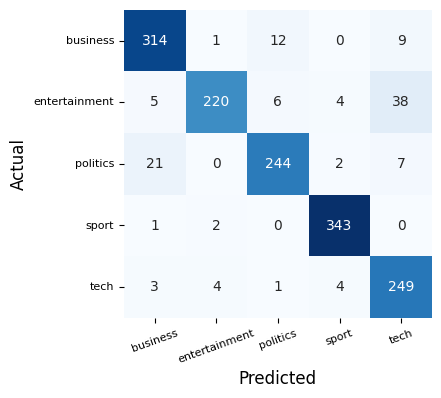

In [27]:
# plot confusion matrix
levels = pd.Index(label_names)
cm = pd.crosstab(levels[y], levels[reordered_yp])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.0f', cbar=False)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8);

In [28]:
DTM_test = tfidf_vectorizer.transform(test.Text)

test_W = model_nmf.transform(DTM_test)
test_predictions = np.argmax(test_W, axis=1)

reordered_test_predictions = np.array([label_mapping[lbl] for lbl in test_predictions])
test_predicted_labels = levels[reordered_test_predictions]

In [29]:
# Kaggle accuracy score: 0.96870
submission = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': test_predicted_labels})

submission.to_csv('submission.csv', index=False)